In [1]:
from utils import dataloader
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from importlib import reload  

import matplotlib.pyplot as plt

import numpy as np

import torch as th
import torch.nn as nn
import os
from datetime import datetime
import matplotlib as mpl
import torch.optim as optim
import pytorch_ssim

import torch.nn.functional as F
import torchvision.models as models
from torch.autograd import Variable
import torchvision.transforms as transforms

In [2]:
dataloader = reload(dataloader)

plotsize = 15

partitions = dataloader.DataPartitions(
    past_frames=6,
    future_frames=1,
    root="../datasets/arda/04_21_full/",
    partial=0.6
)

dataset = dataloader.DataGenerator(
    root="../datasets/arda/04_21_full/",
    dataset_partitions=partitions.get_partitions(),
    past_frames=partitions.past_frames, 
    future_frames=partitions.future_frames,
    input_dim=(partitions.past_frames, 256, 256, 4),
    output_dim=(partitions.future_frames, 256, 256, 3),
    batch_size=4,
    buffer_size=1e3,
    buffer_memory=100,
    downsampling=False,
    dynamicity = 1e-2
)

In [3]:
X, Y, extra_batch = dataset.get_data()

X[X > 10e5] = 0 
Y[Y > 10e5] = 0


[x] 14 areas found
. . . . . . . . . . . . . . . . 
[7%] 16 valid sequences loaded
. . . . . . . . . . . . . . . . 
[14%] 16 valid sequences loaded
. . . . . . . . . . . . . . . . 
[21%] 16 valid sequences loaded
. . . . . . . . . . . . . . . . 
[29%] 16 valid sequences loaded
. . . . . . . . . . . . . . . . 
[36%] 16 valid sequences loaded
. . . . . . . . . . . . . . . . 
[43%] 16 valid sequences loaded
. . . . . . . . . . . . . . . . 
[50%] 16 valid sequences loaded
. . . . . . . . . . . . . . . . 
[57%] 16 valid sequences loaded
. . . . . . . . . . . . . . . . 
[64%] 16 valid sequences loaded
. . . . . . . . . . . . . . . . 
[71%] 16 valid sequences loaded
. . . . . . . . . . . . . . . . 
[79%] 16 valid sequences loaded
. . . . . . . . . . . . . . . . 
[86%] 16 valid sequences loaded
. . . . . . . . . . . . . . . . 
[93%] 16 valid sequences loaded
. . . . . . . . . . . . . . . . 
[100%] 16 valid sequences loaded


In [4]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X, Y = unison_shuffled_copies(X, Y)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [6]:
X_train.shape


(44, 4, 6, 256, 256, 4)

In [7]:
print("DEP min: {}\nVEL min: {}\nBTM min: {}".format(
    np.min(X_train[:, :, :, :, :, 0]),
    np.min(X_train[:, :, :, :, :, 1]),
    np.min(X_train[:, :, :, :, :, 2])
))

print("DEP max: {}\nVEL max: {}\nBTM max: {}".format(
    np.max(X_train[:, :, :, :, :, 0]),
    np.max(X_train[:, :, :, :, :, 1]),
    np.max(X_train[:, :, :, :, :, 2])
))

DEP min: 0.0
VEL min: -2.82978
BTM min: -0.593146
DEP max: 4.16357
VEL max: 5.48189
BTM max: 6.64461


### Model

In [8]:
import torch.nn.functional as F
from functools import partial

In [9]:
def xavier_weights(m):
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        th.nn.init.xavier_uniform(m.weight.data)

def sqrt_weights(m):
    # https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [10]:
if th.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = th.device(dev)
print(device)

cuda:0


In [47]:
from models.ae import ConvLSTMCell
from models.ae import seq2seq_ConvLSTM
seq2seq_ConvLSTM = reload(seq2seq_ConvLSTM)

net = seq2seq_ConvLSTM.EncoderDecoderConvLSTM(nf=4, in_chan=4).to(device) # False: many to one

In [12]:
X_train = th.Tensor(X_train).to(device)
y_train = th.Tensor(y_train).to(device)

In [13]:
# b, s, t, h, w, c -> b, s, t, c, h, w
X_train = X_train.permute(0, 1, 2, 5, 3, 4)
y_train = y_train.permute(0, 1, 2, 5, 3, 4)

In [14]:
X_test = th.Tensor(X_test).to(device)
y_test = th.Tensor(y_test).to(device)

In [15]:
# b, s, t, h, w, c -> b, s, t, c, h, w
X_test = X_test.permute(0, 1, 2, 5, 3, 4)
y_test = y_test.permute(0, 1, 2, 5, 3, 4)

torch.Size([44, 4, 6, 4, 256, 256])


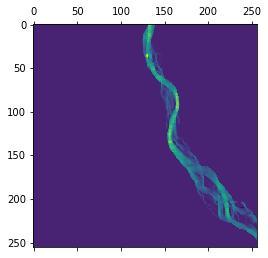

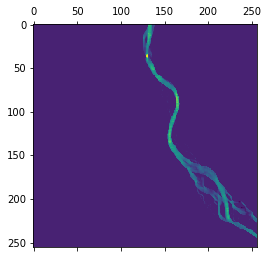

In [16]:
plt.matshow(X_train[5,2,0,2,:,:].cpu().numpy())
plt.matshow(y_train[5,2,0,2,:,:].cpu().numpy())
print(X_train.shape)

<ipython-input-22-37b3e947f1d3>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, sequence.shape[0], figsize=(plotsize,plotsize))


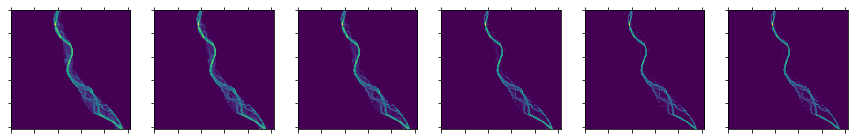

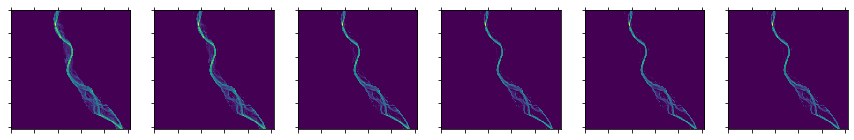

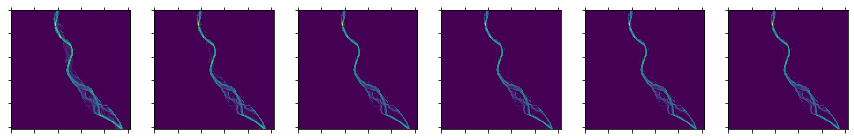

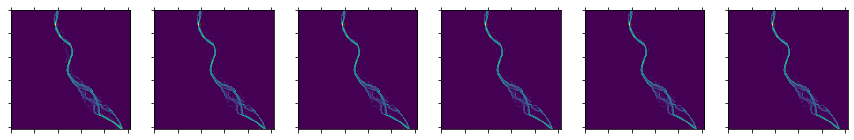

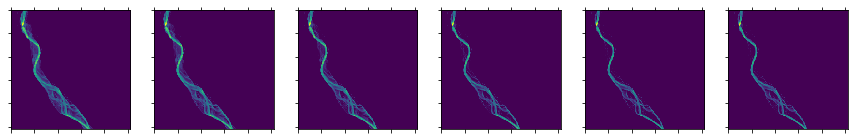

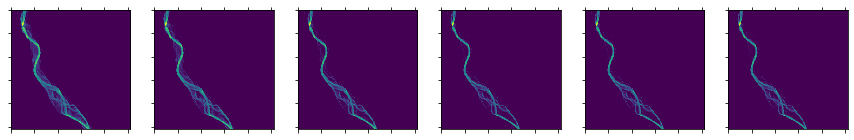

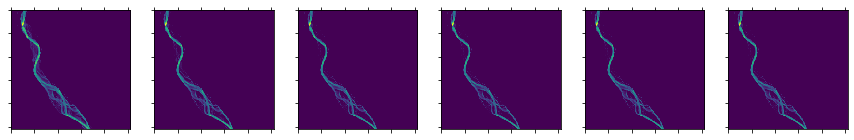

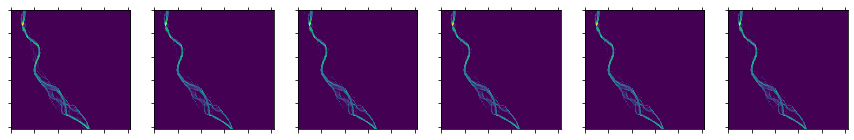

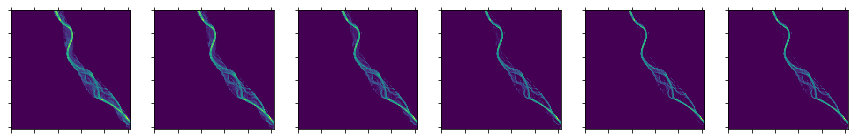

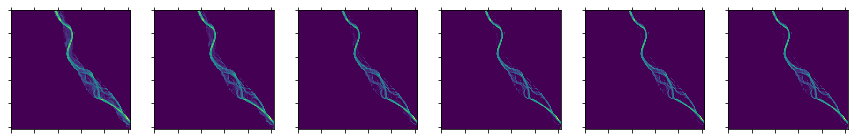

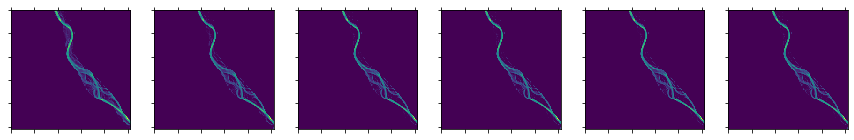

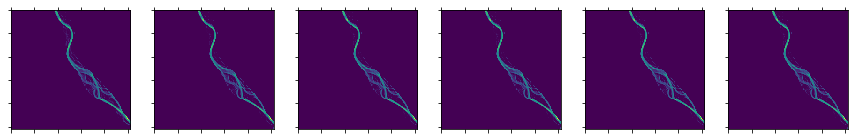

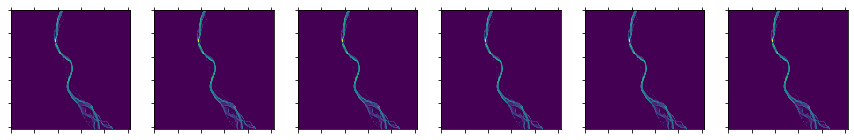

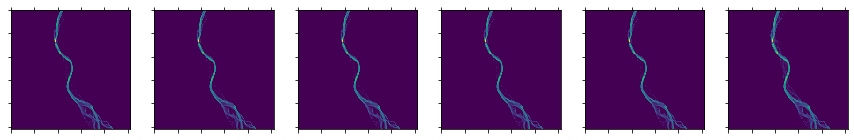

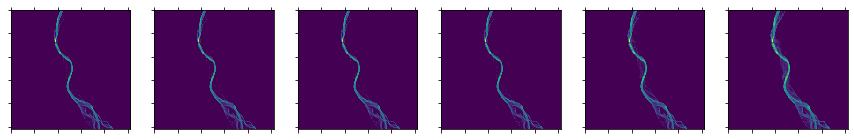

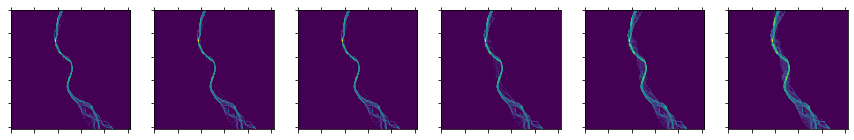

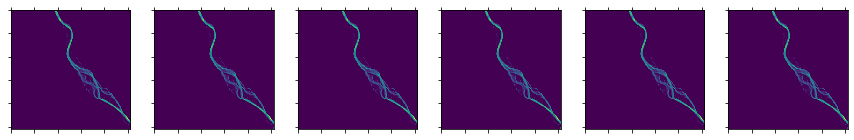

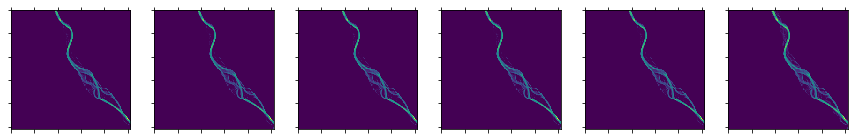

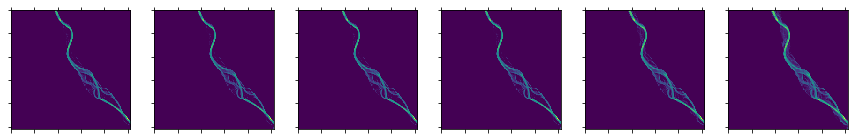

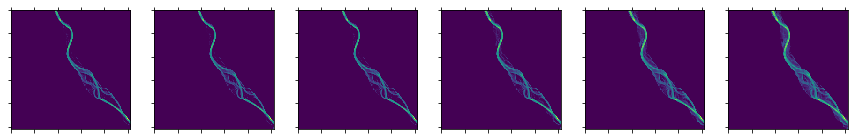

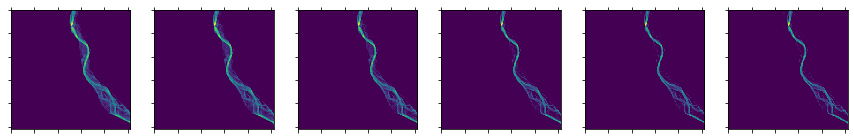

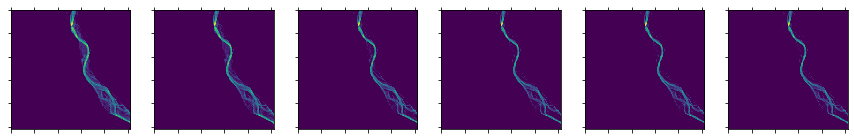

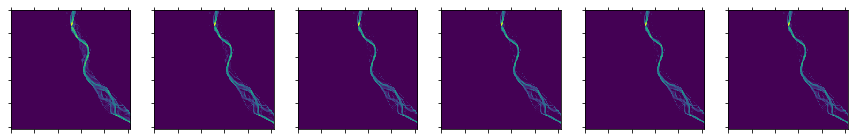

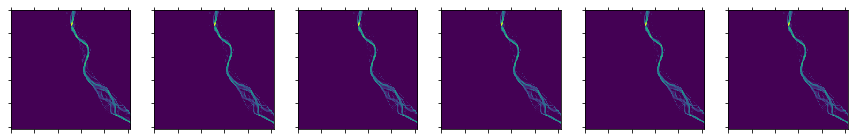

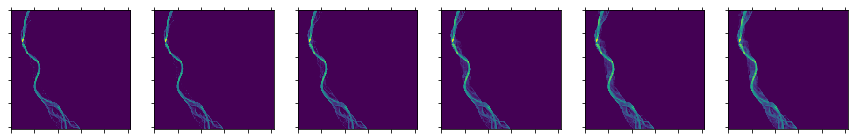

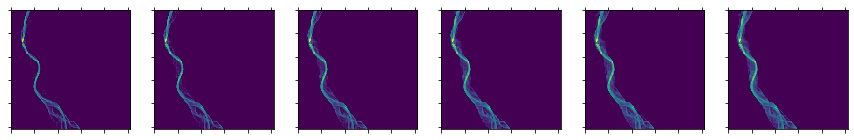

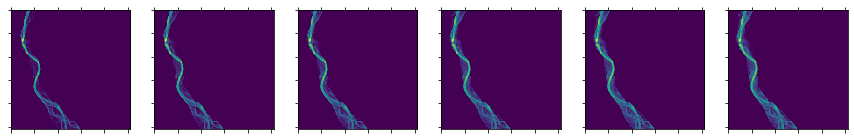

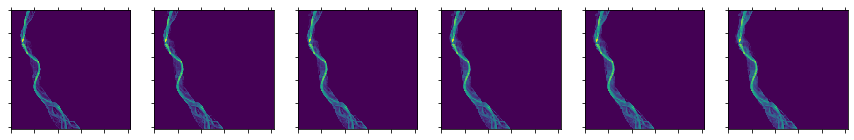

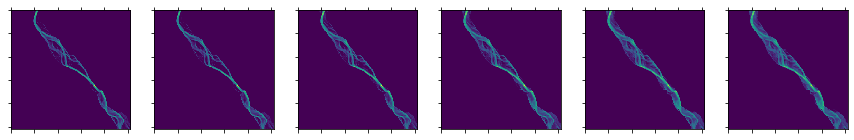

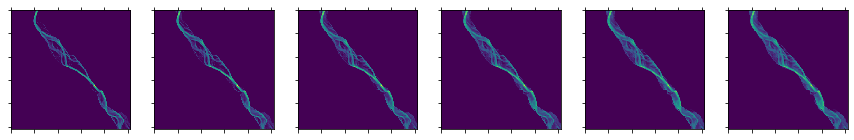

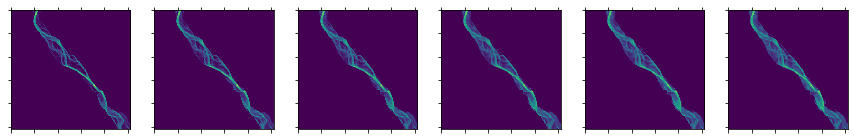

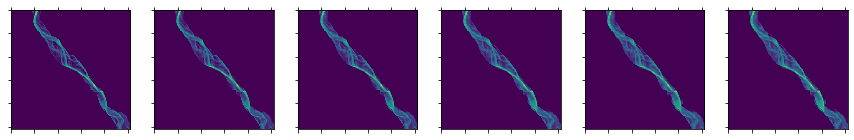

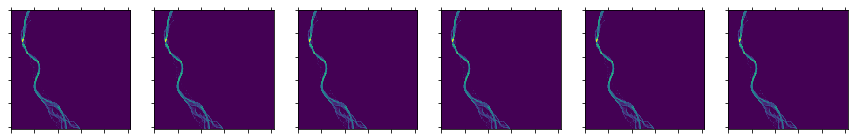

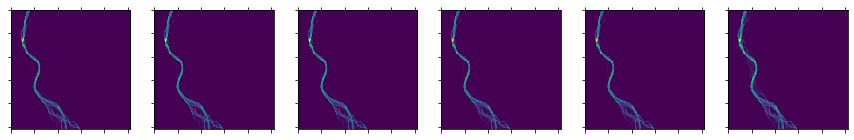

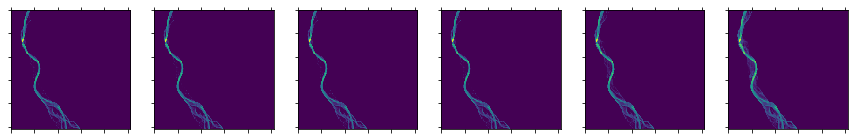

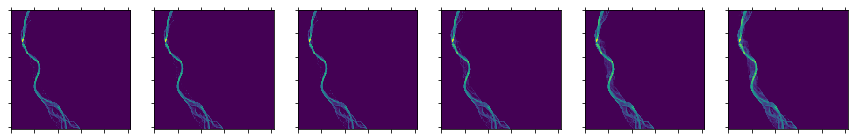

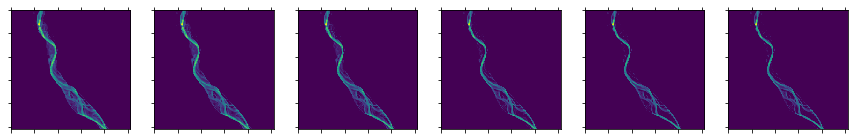

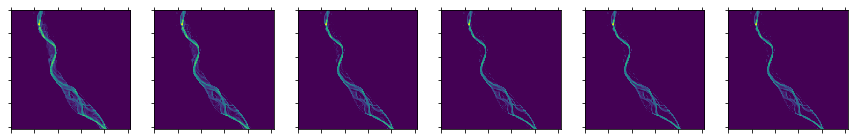

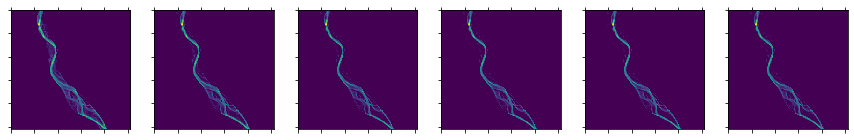

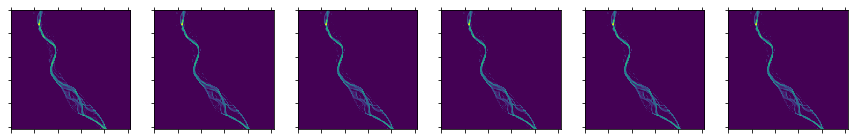

In [22]:
# Valid sequences
for i, batch in enumerate(X_train):

    if i == 10: break
    for j, sequence in enumerate(batch):

        # first three channels (dep, vvx, vvy): x/y aligned
        #sequence = np.concatenate((sequence[:,:3,:,:], y_train[i,j,:,0,:,:].unsqueeze(0)), axis=0)

        fig, axs = plt.subplots(1, sequence.shape[0], figsize=(plotsize,plotsize))

        for ax in axs:
            ax.set_yticklabels([])
            ax.set_xticklabels([])

        for k,frame in enumerate(sequence):   # x frames
            axs[k].matshow(frame[0].cpu().numpy())

In [48]:
#criterion = pytorch_ssim.SSIM()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [49]:
losses = []
errors = []
test_errors = []

def mass_conservation_loss(output, target):
    # output: b, h, w
    diff = 0
    for i,datapoint in enumerate(output):
        diff += th.abs(
            th.sum(
                th.abs(output[i])
            ) -
            th.sum(
                th.abs(target[i])
            )
        )
    return diff**(1/2)

epoch 0 -- avg loss: 0.07628570552068678
[!] Comparison matrices printed


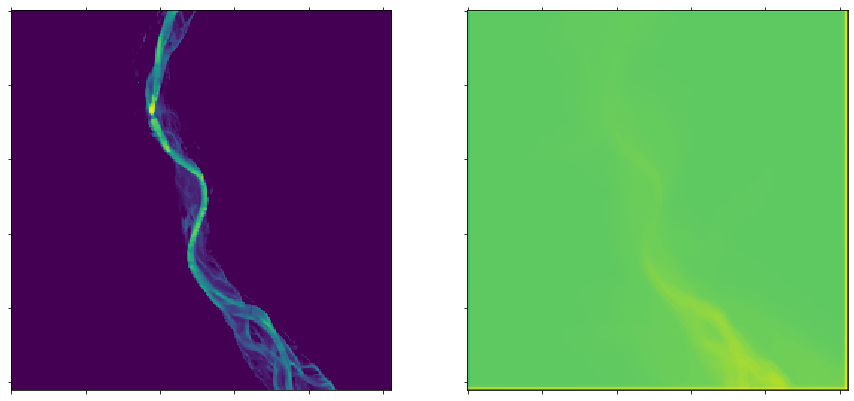

epoch 1 -- avg loss: 0.07620898136784407
[!] Comparison matrices printed


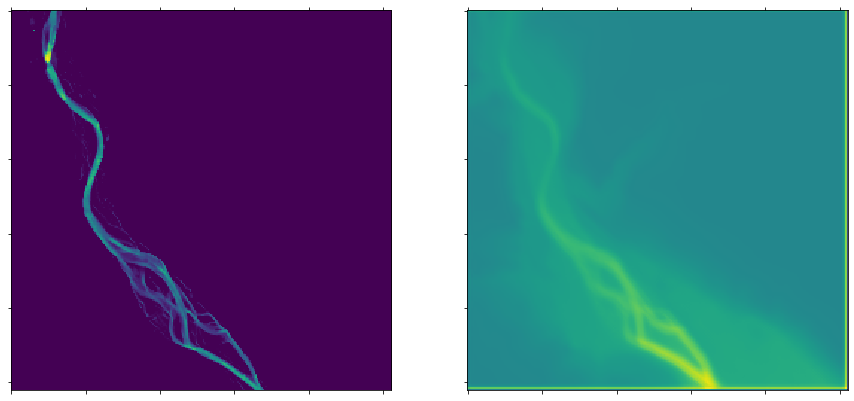

epoch 2 -- avg loss: 0.07605947218270916
[!] Comparison matrices printed


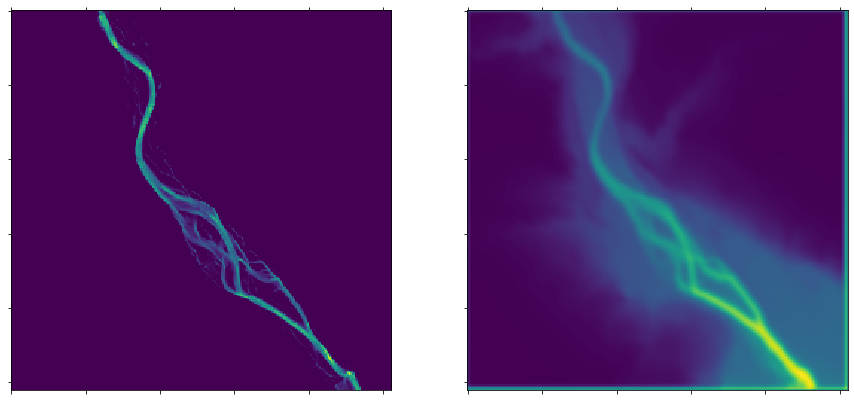

epoch 3 -- avg loss: 0.07549430995078926
[!] Comparison matrices printed


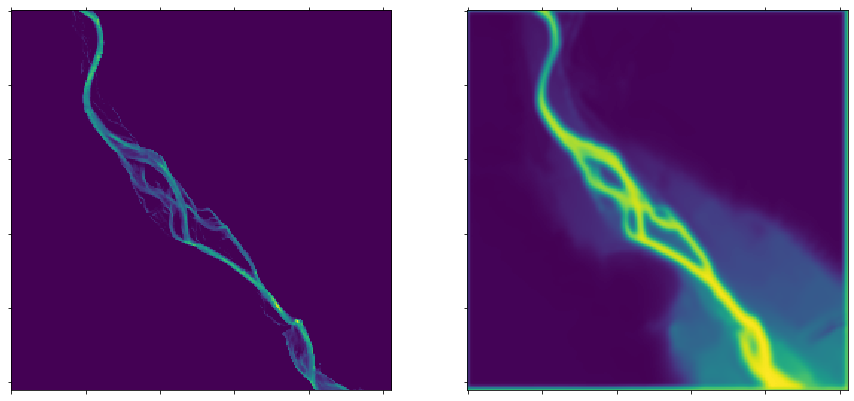

epoch 4 -- avg loss: 0.0743931239047511
[!] Comparison matrices printed


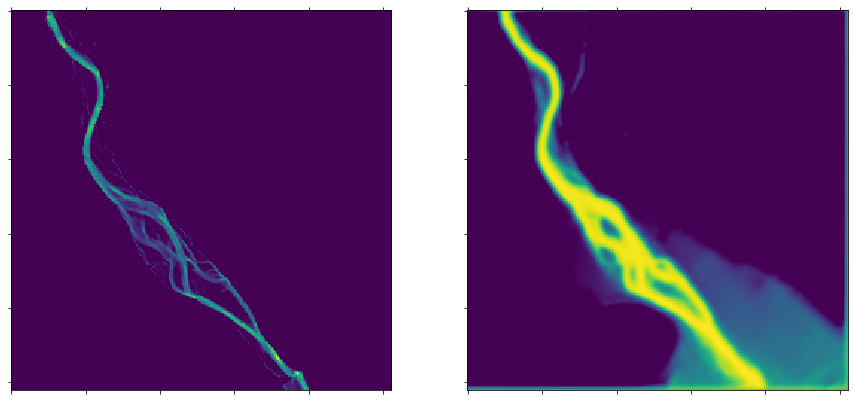

epoch 5 -- avg loss: 0.07311050146535943
[!] Comparison matrices printed


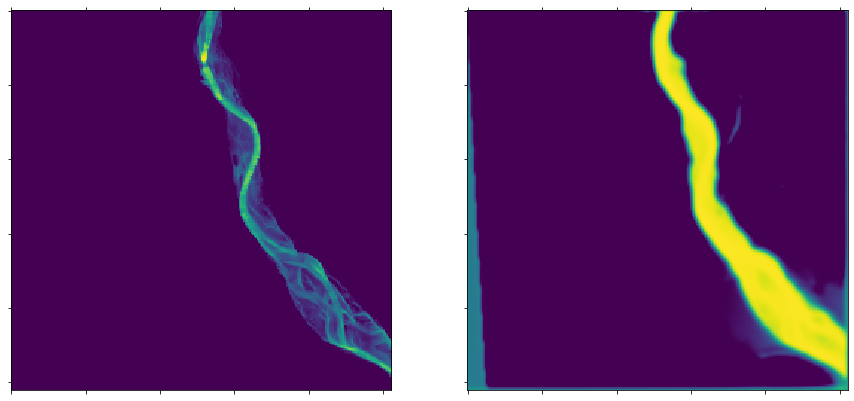

epoch 6 -- avg loss: 0.07146929432456563
[!] Comparison matrices printed


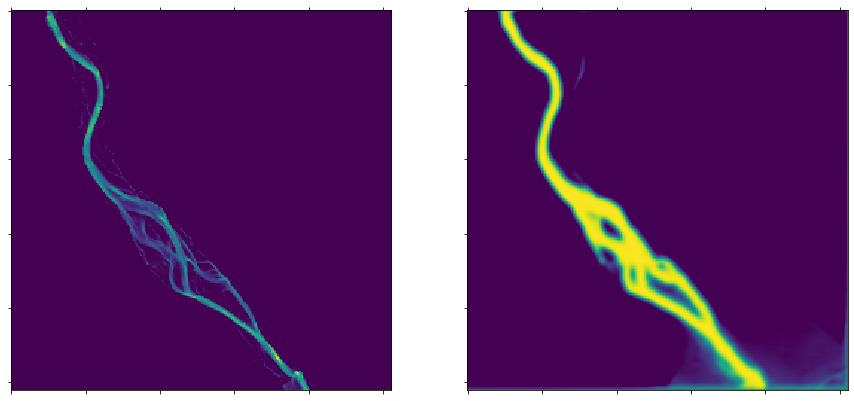

epoch 7 -- avg loss: 0.06931602793205953
[!] Comparison matrices printed


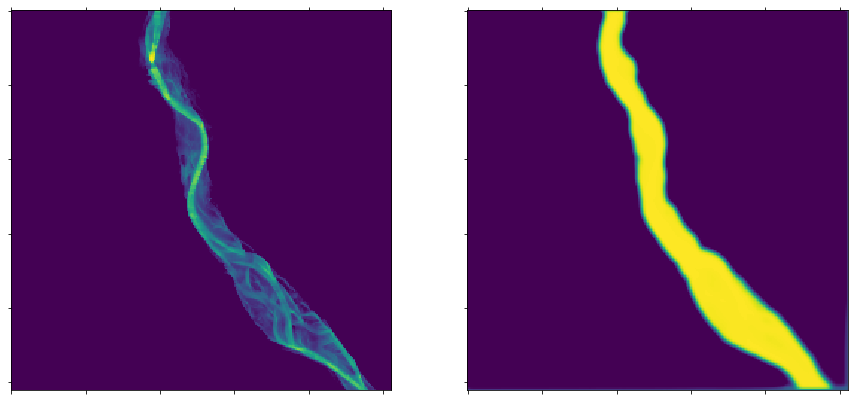

epoch 8 -- avg loss: 0.0667524081396146
[!] Comparison matrices printed


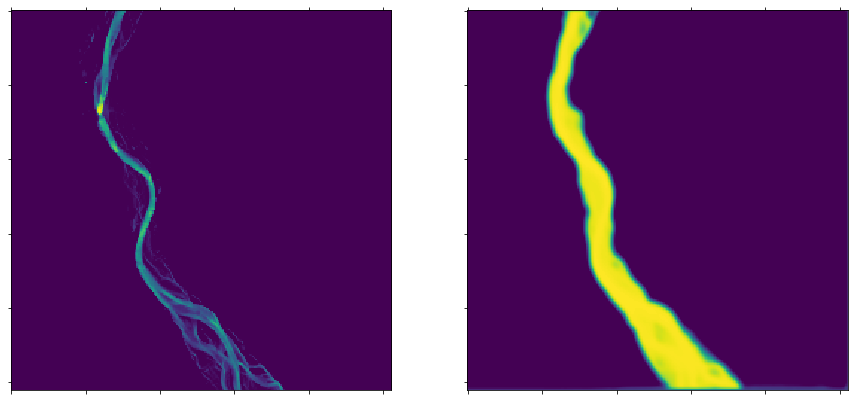

epoch 9 -- avg loss: 0.06403676732443273
[!] Comparison matrices printed


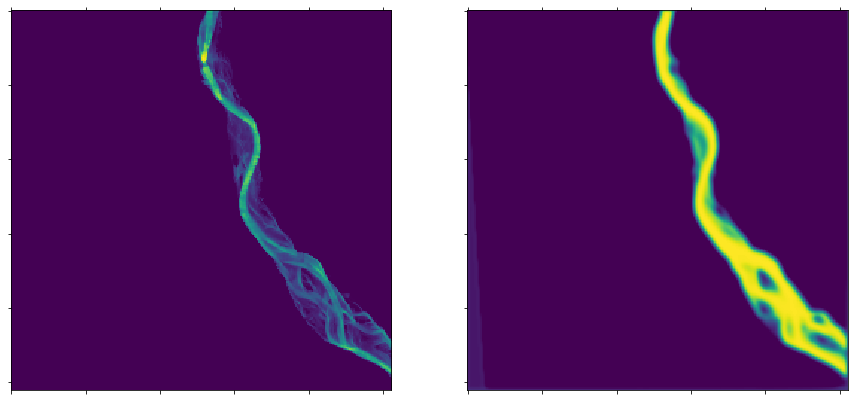

epoch 10 -- avg loss: 0.061341979277266326
[!] Comparison matrices printed


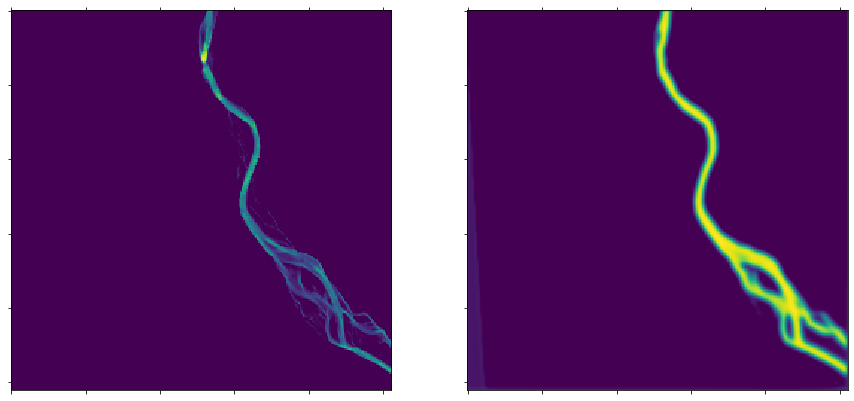

epoch 11 -- avg loss: 0.05873242100245658
[!] Comparison matrices printed


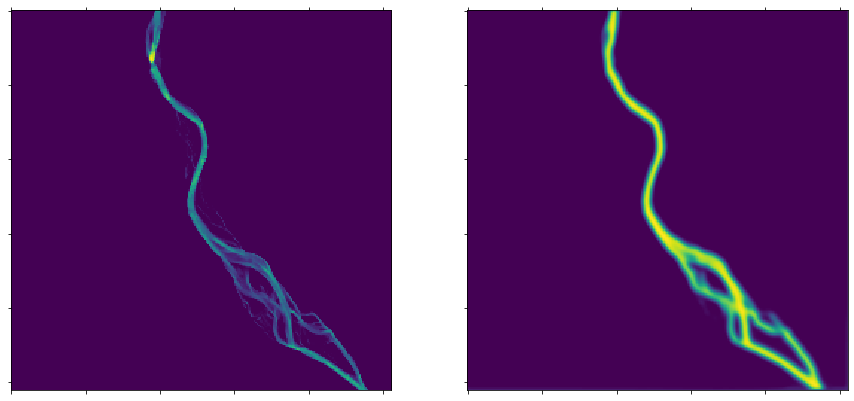

epoch 12 -- avg loss: 0.056253290503168595
[!] Comparison matrices printed


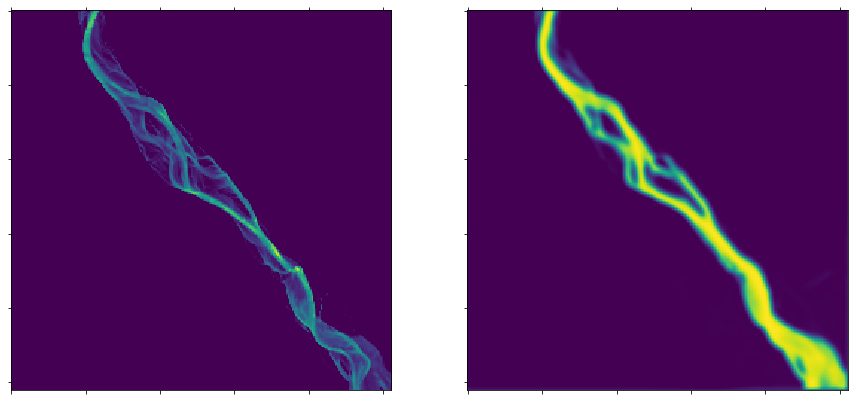

epoch 13 -- avg loss: 0.053940710776437126
[!] Comparison matrices printed


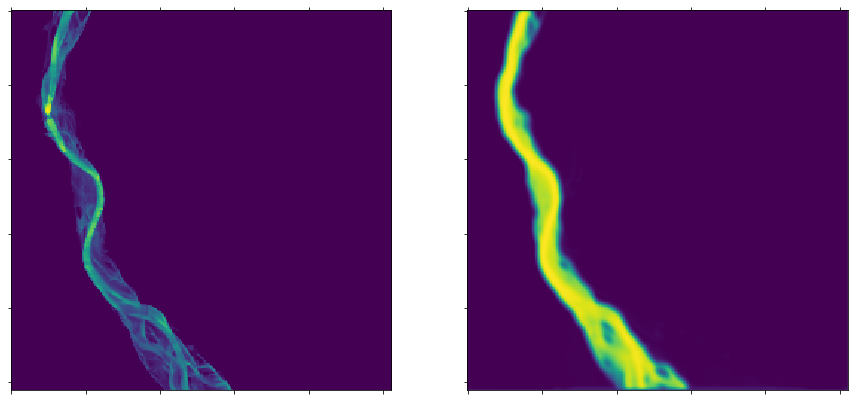

epoch 14 -- avg loss: 0.0518067892252778
[!] Comparison matrices printed


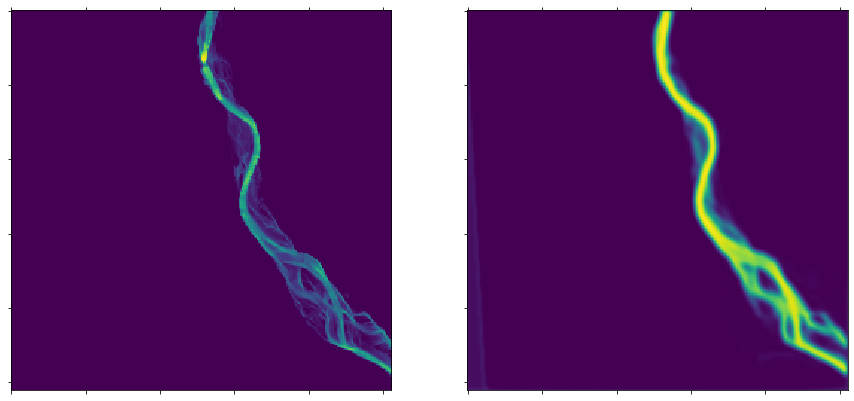

epoch 15 -- avg loss: 0.049848214237664994
[!] Comparison matrices printed


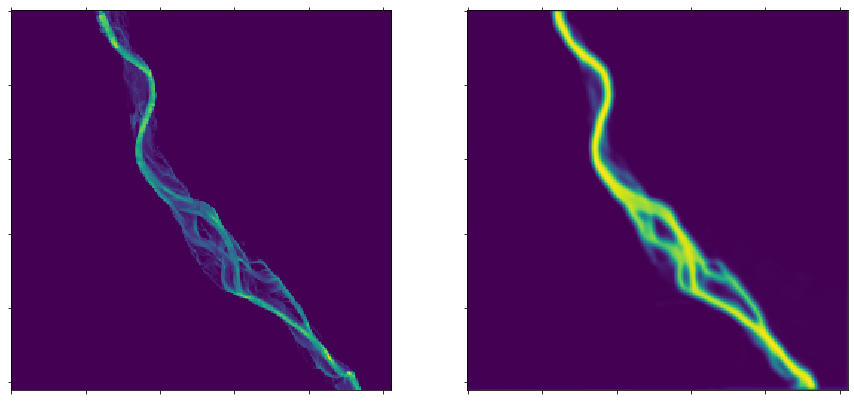

epoch 16 -- avg loss: 0.048053424267526616
[!] Comparison matrices printed


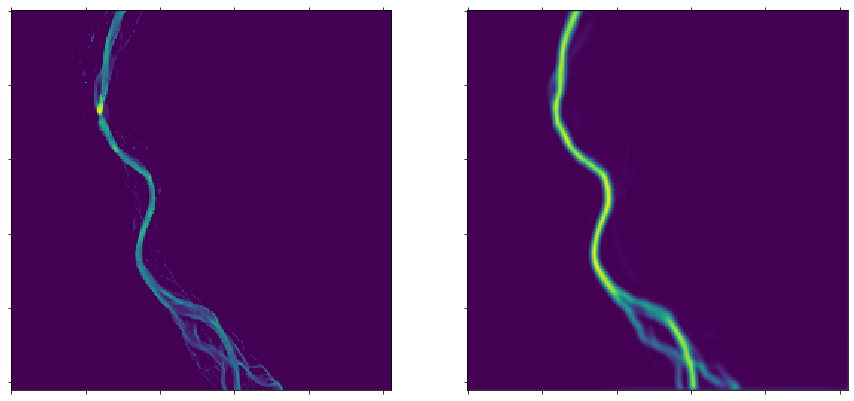

epoch 17 -- avg loss: 0.0464060914413439
[!] Comparison matrices printed


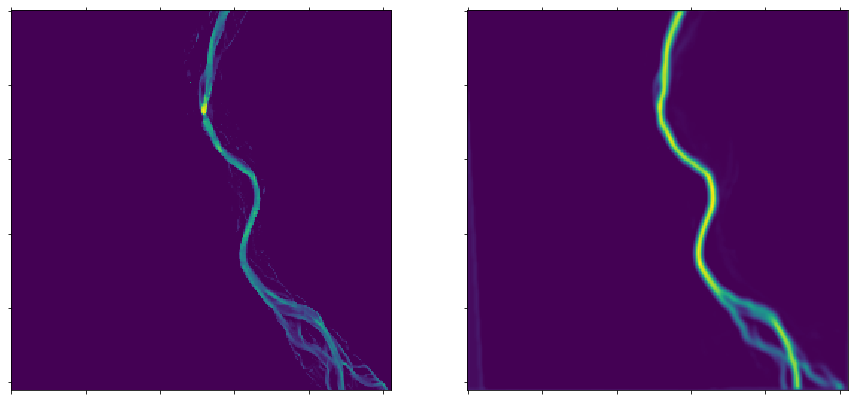

epoch 18 -- avg loss: 0.0448878556016485
[!] Comparison matrices printed


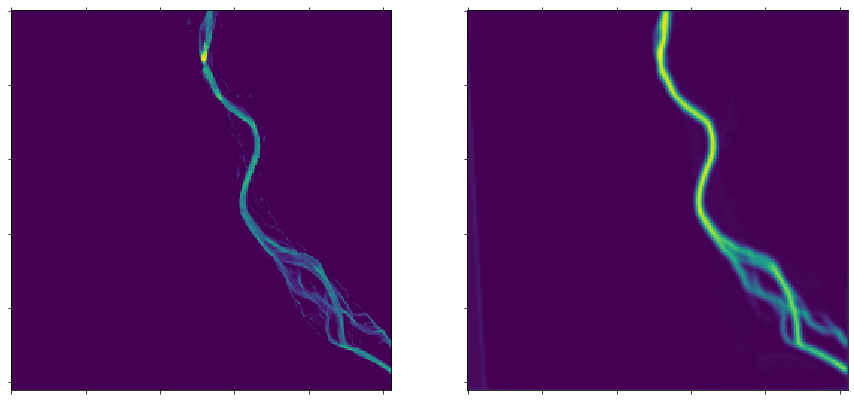

epoch 19 -- avg loss: 0.04348063568203625
[!] Comparison matrices printed


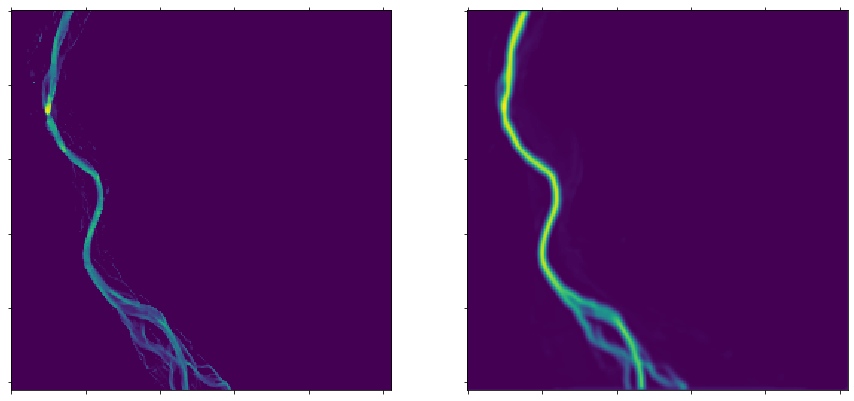

epoch 20 -- avg loss: 0.042168817560750894
[!] Comparison matrices printed


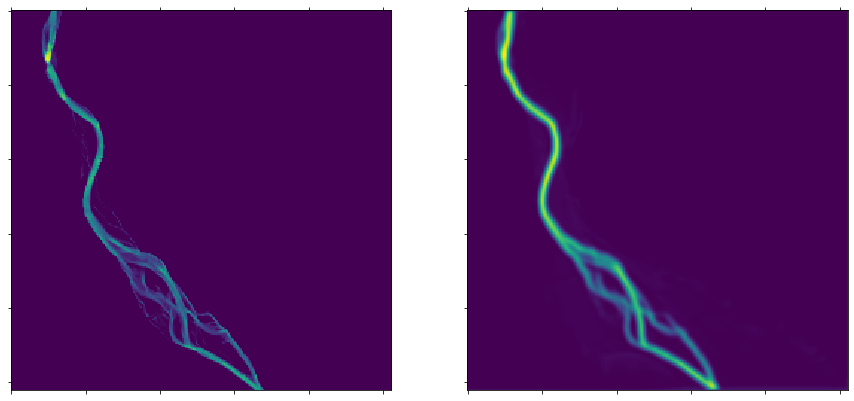

epoch 21 -- avg loss: 0.040941073585201576
[!] Comparison matrices printed


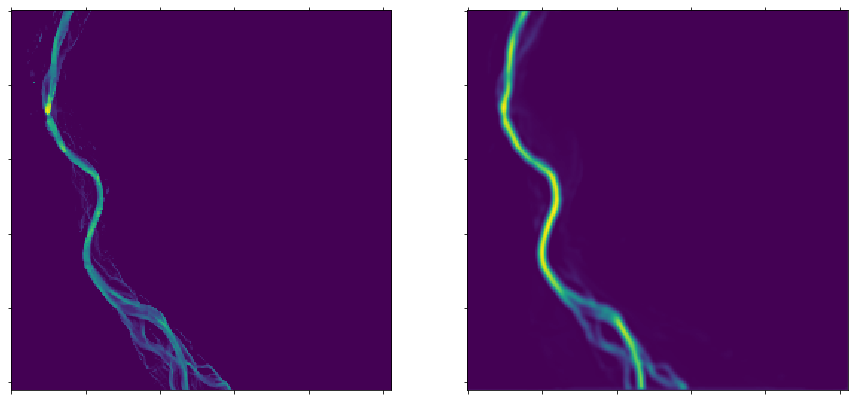

epoch 22 -- avg loss: 0.0397910006181429
[!] Comparison matrices printed


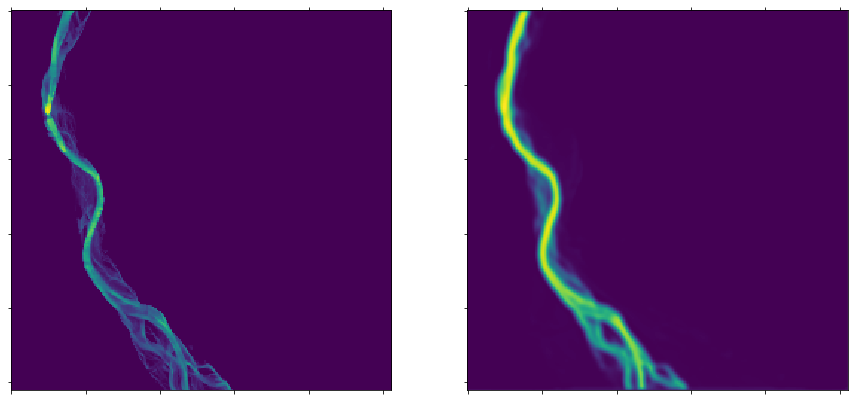

epoch 23 -- avg loss: 0.038713764352768056
[!] Comparison matrices printed


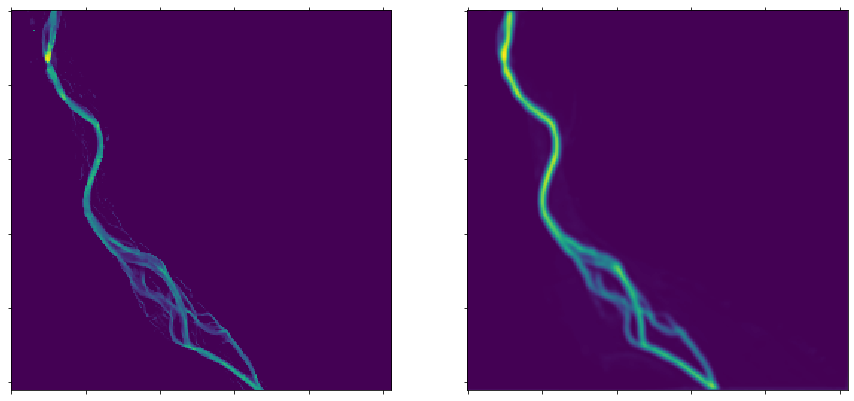

epoch 24 -- avg loss: 0.03770395701391284
[!] Comparison matrices printed


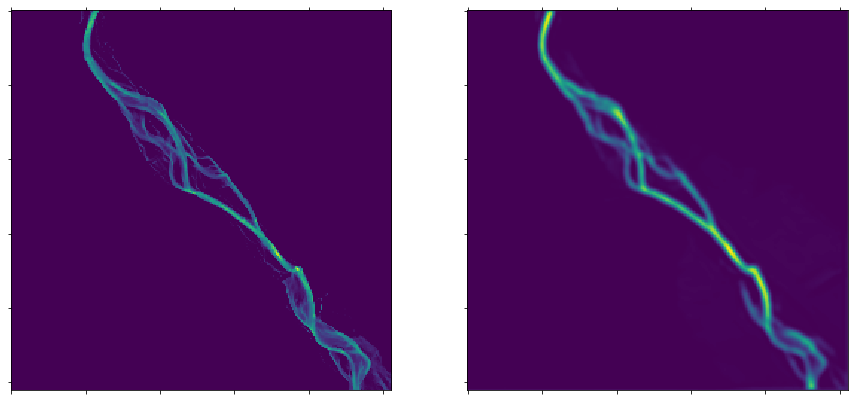

epoch 25 -- avg loss: 0.03675539468490792
[!] Comparison matrices printed


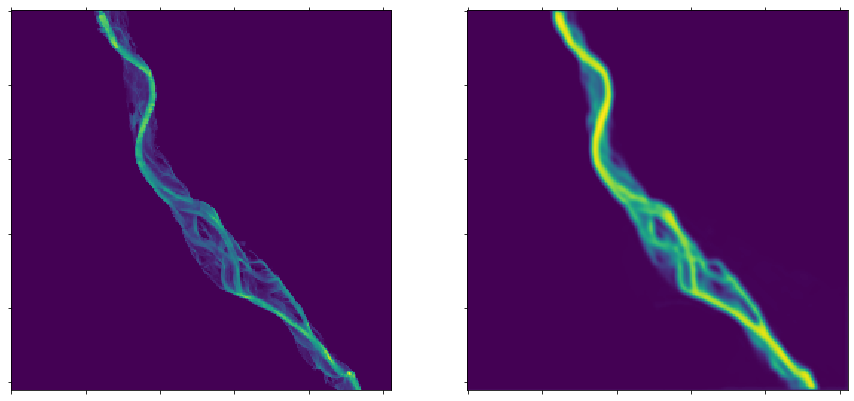

epoch 26 -- avg loss: 0.03586251529381275
[!] Comparison matrices printed


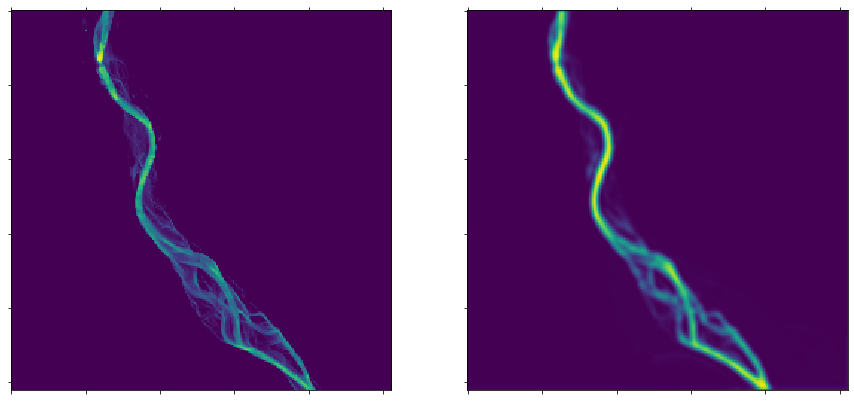

epoch 27 -- avg loss: 0.03502086280635709
[!] Comparison matrices printed


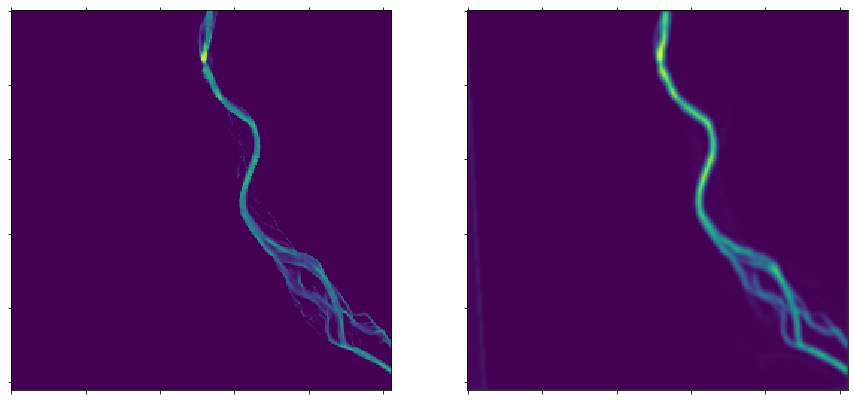

epoch 28 -- avg loss: 0.03422656956914853
[!] Comparison matrices printed


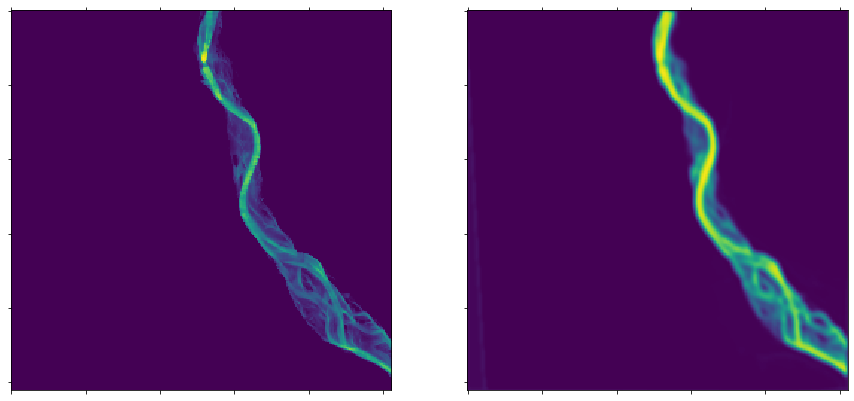

epoch 29 -- avg loss: 0.033476046964201624
[!] Comparison matrices printed


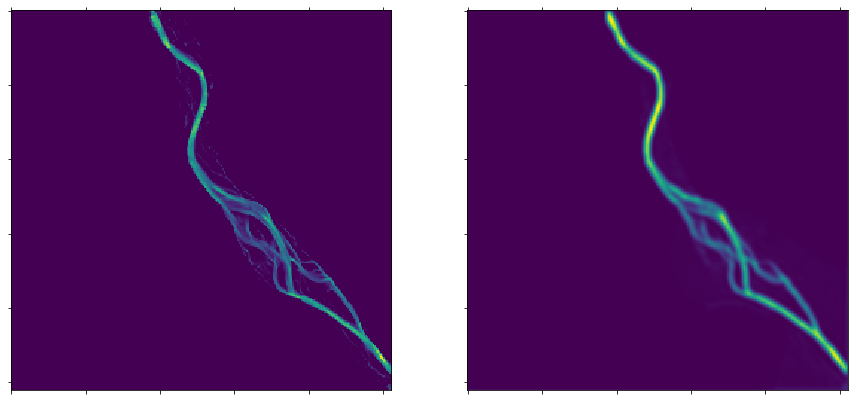

epoch 30 -- avg loss: 0.03276594471725119
[!] Comparison matrices printed


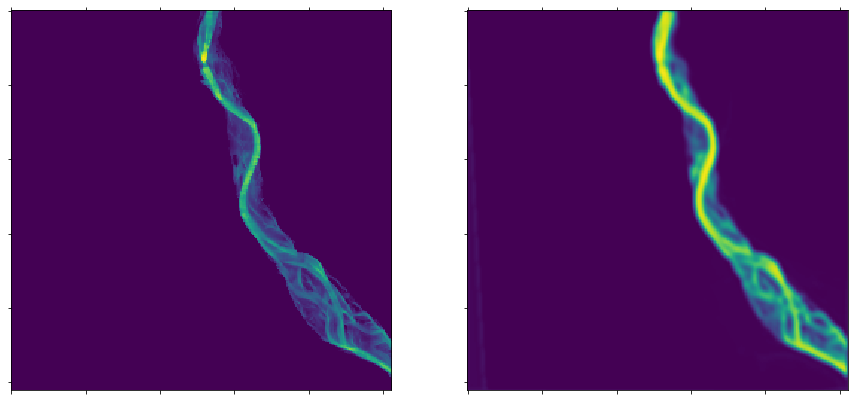

epoch 31 -- avg loss: 0.032093163281222754
[!] Comparison matrices printed


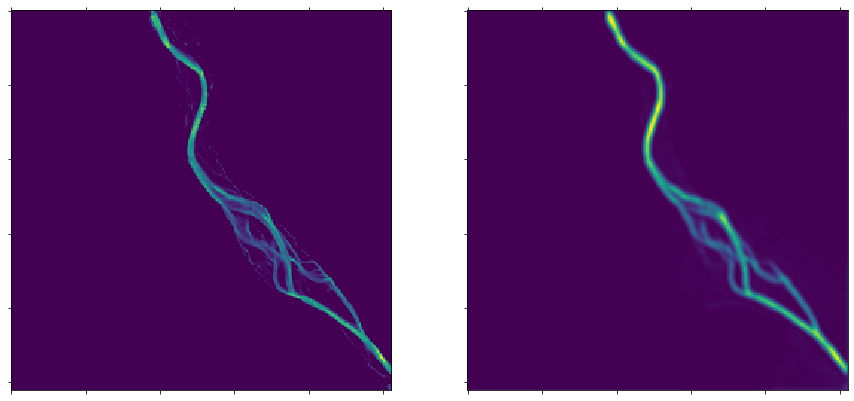

epoch 32 -- avg loss: 0.0314548583279528
[!] Comparison matrices printed


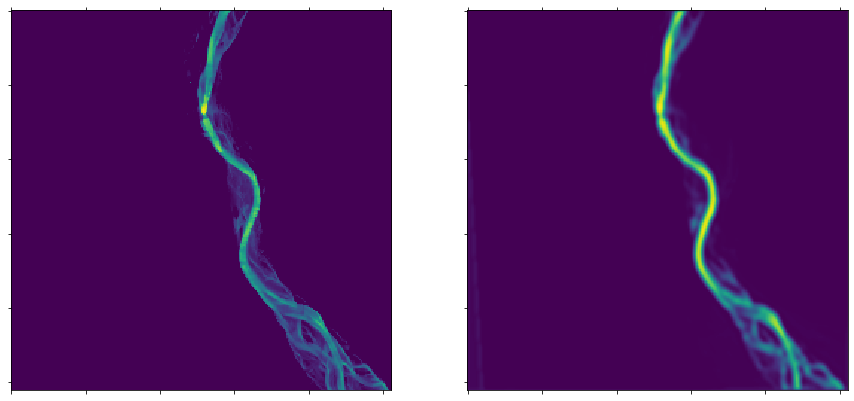

epoch 33 -- avg loss: 0.03084842427394024
[!] Comparison matrices printed


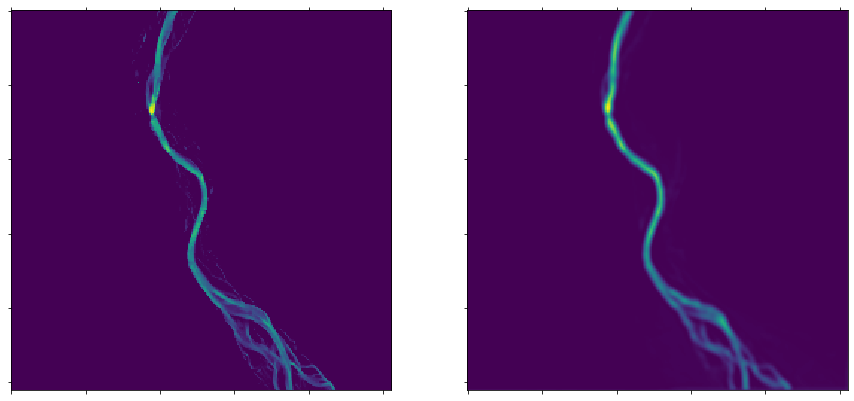

epoch 34 -- avg loss: 0.030271479729623473
[!] Comparison matrices printed


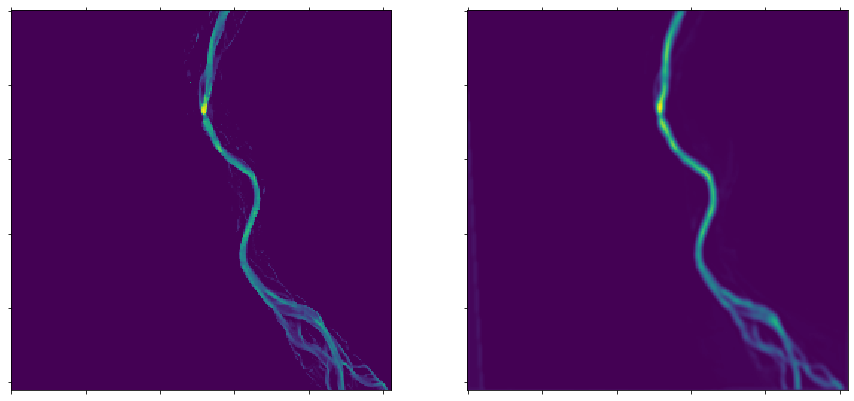

epoch 35 -- avg loss: 0.02972185577388213
[!] Comparison matrices printed


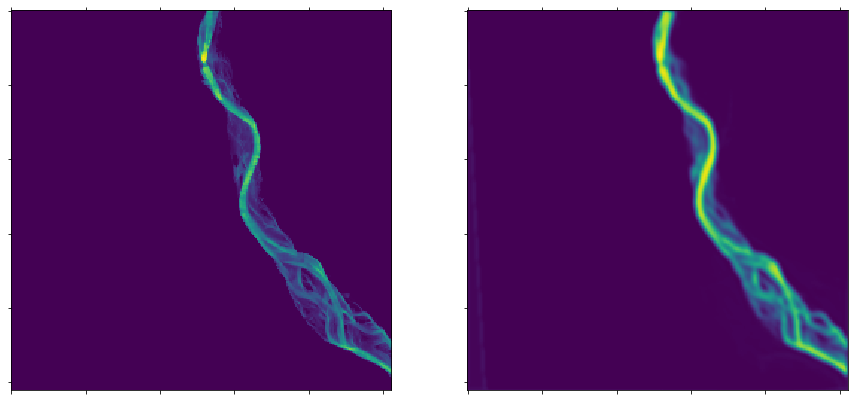

epoch 36 -- avg loss: 0.029197577981327497
[!] Comparison matrices printed


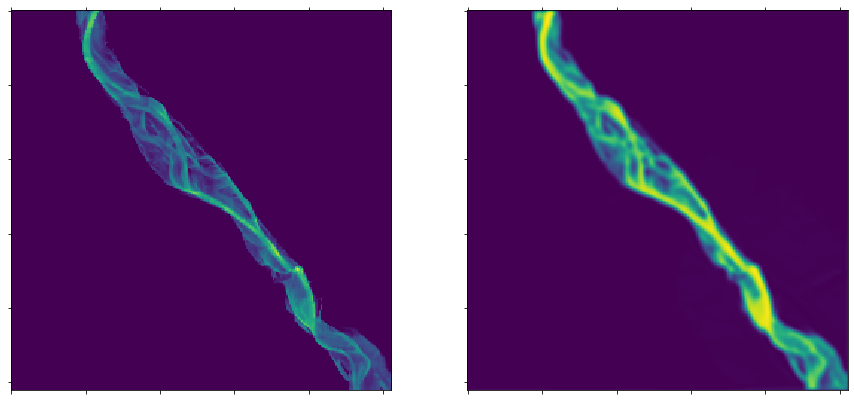

epoch 37 -- avg loss: 0.028696853855488886
[!] Comparison matrices printed


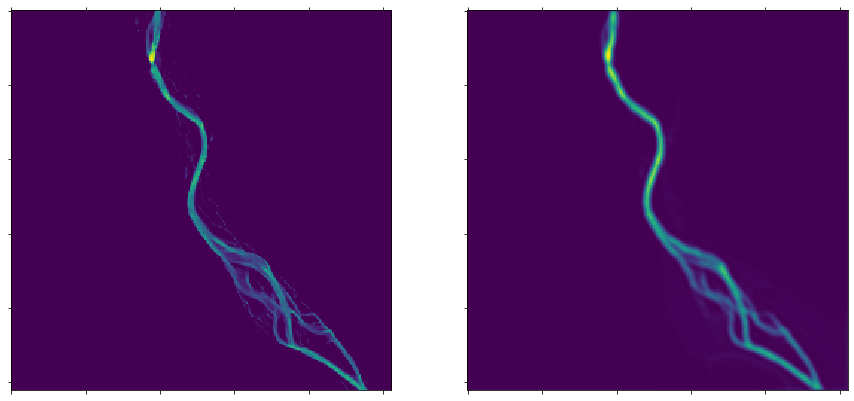

epoch 38 -- avg loss: 0.028218052895698426
[!] Comparison matrices printed


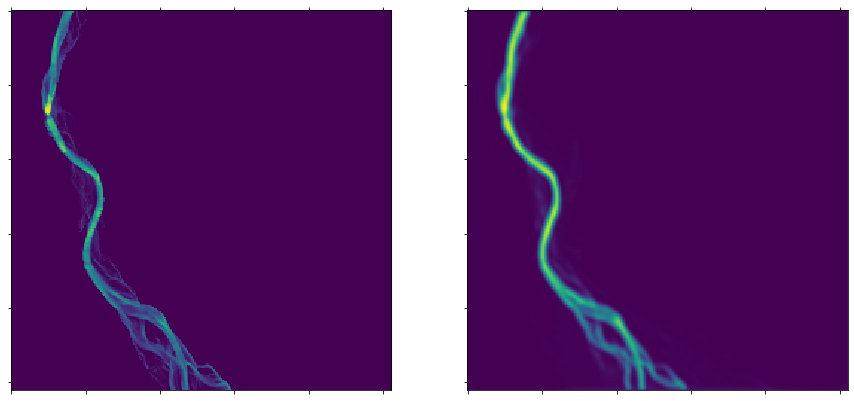

epoch 39 -- avg loss: 0.027759697267505212
[!] Comparison matrices printed


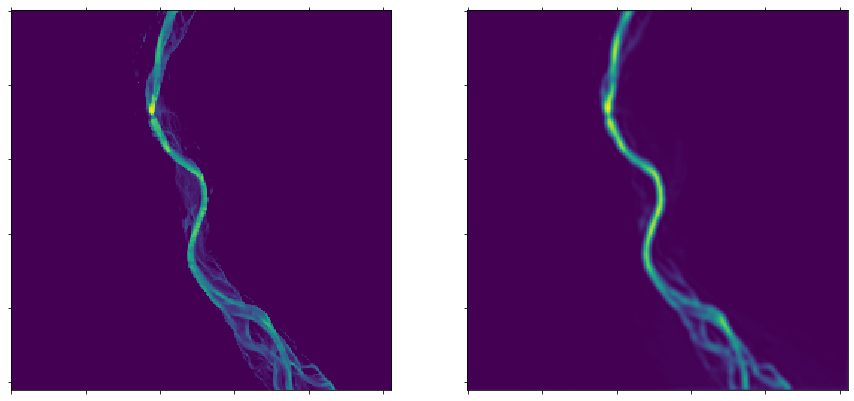

epoch 40 -- avg loss: 0.02732044360713988
[!] Comparison matrices printed


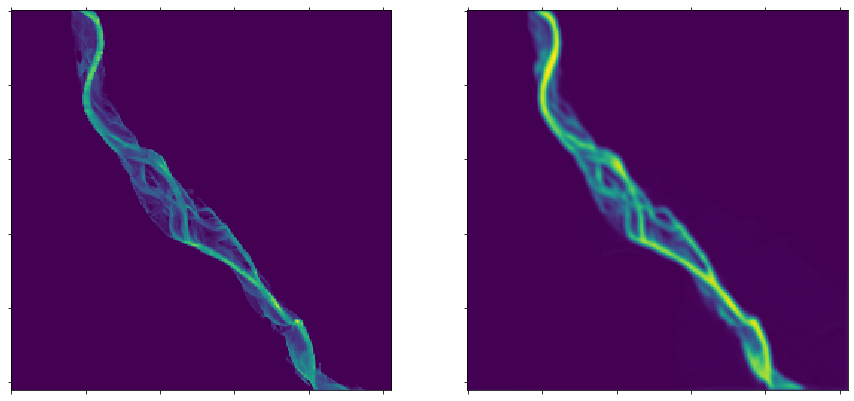

epoch 41 -- avg loss: 0.02689906912974235
[!] Comparison matrices printed


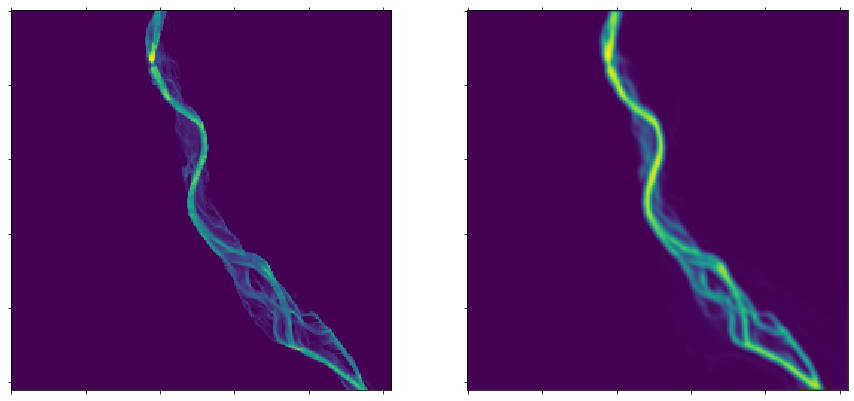

epoch 42 -- avg loss: 0.026494458849501478
[!] Comparison matrices printed


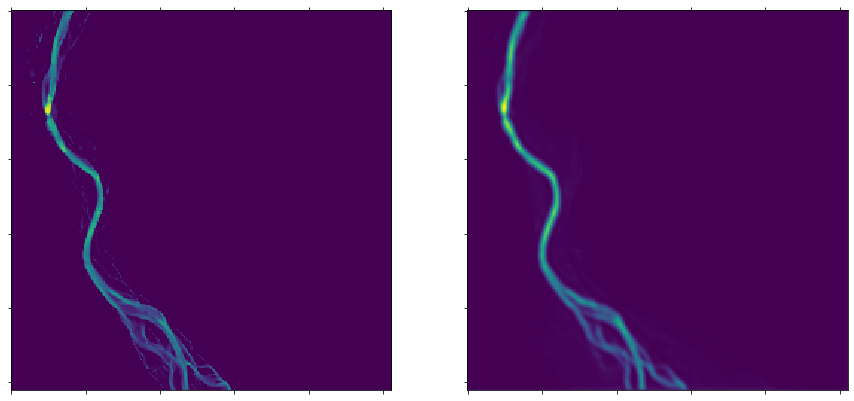

epoch 43 -- avg loss: 0.026105594571726974
[!] Comparison matrices printed


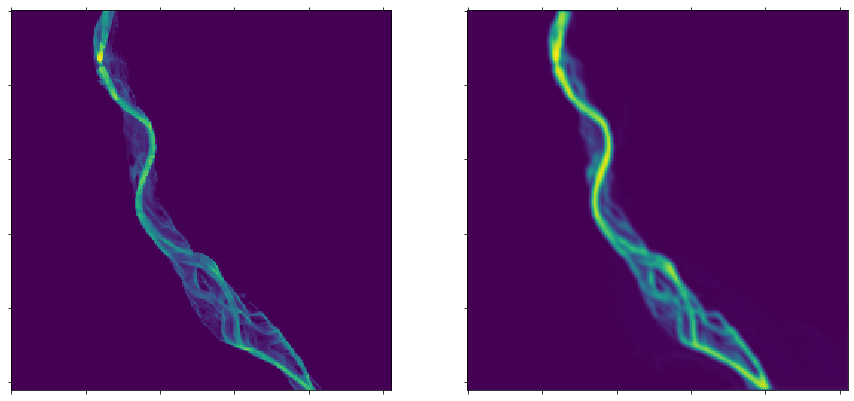

epoch 44 -- avg loss: 0.025731542493061473
[!] Comparison matrices printed


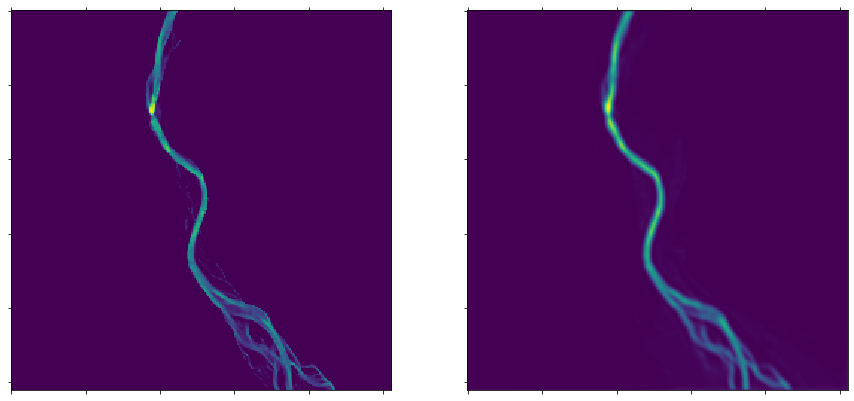

epoch 45 -- avg loss: 0.025371442643949475
[!] Comparison matrices printed


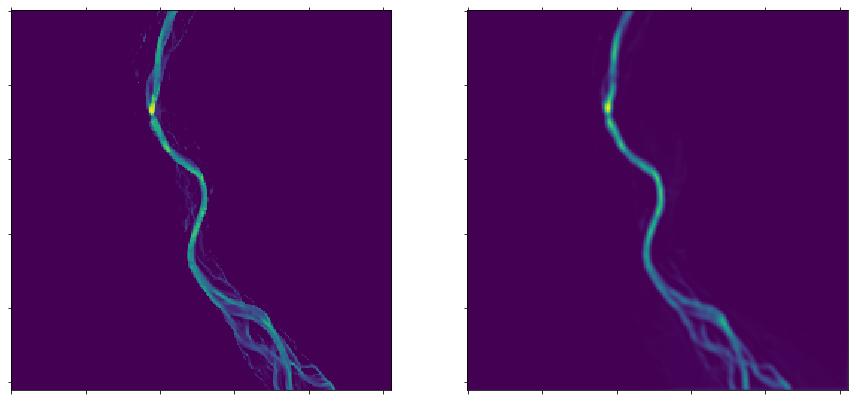

epoch 46 -- avg loss: 0.025024501007857303
[!] Comparison matrices printed


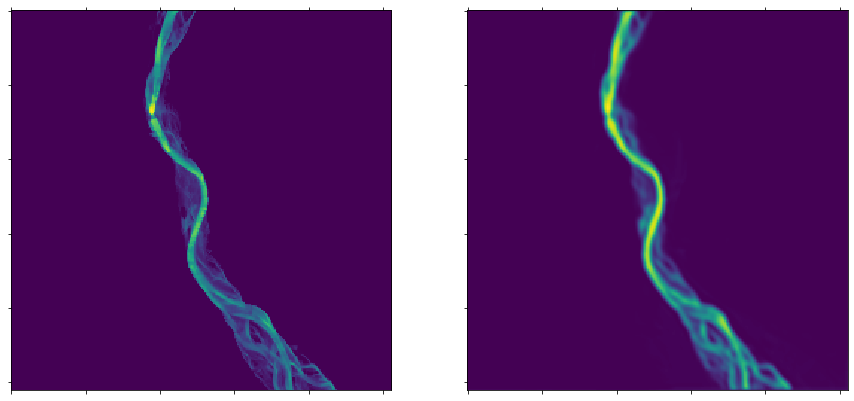

epoch 47 -- avg loss: 0.024689983913214582
[!] Comparison matrices printed


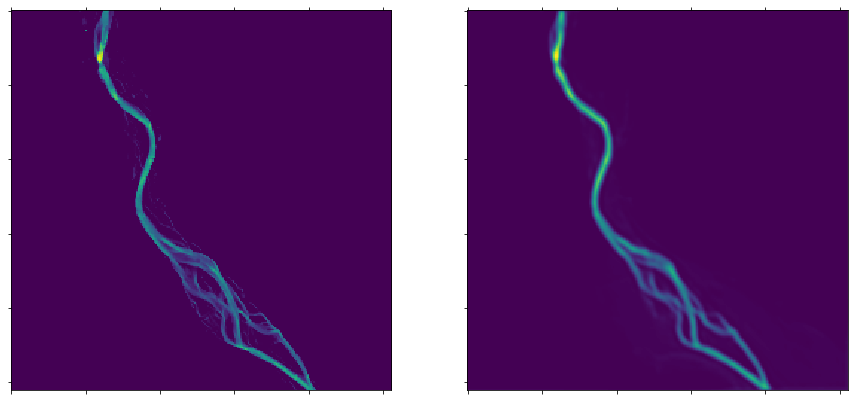

epoch 48 -- avg loss: 0.02436721207749389
[!] Comparison matrices printed


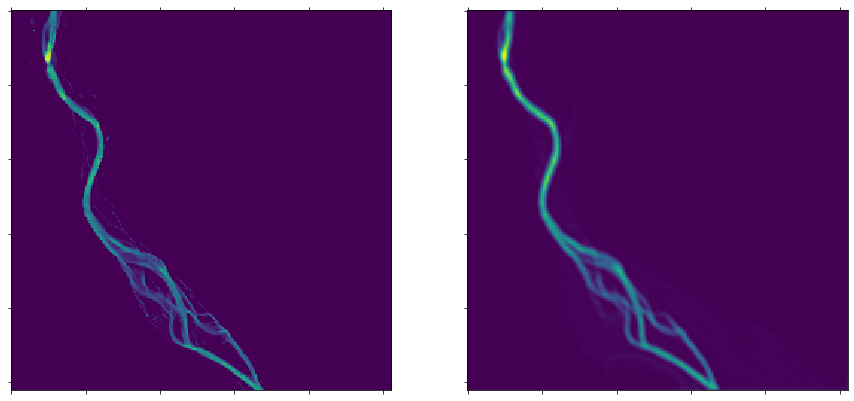

epoch 49 -- avg loss: 0.02405555520164357
[!] Comparison matrices printed


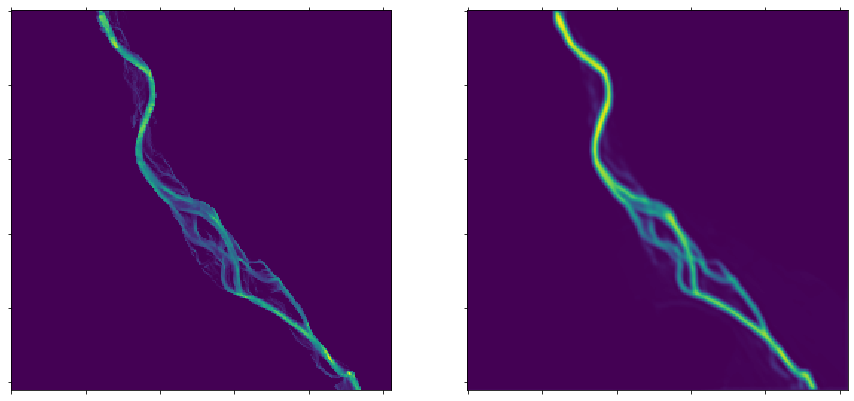

epoch 50 -- avg loss: 0.023754429753721194
[!] Comparison matrices printed


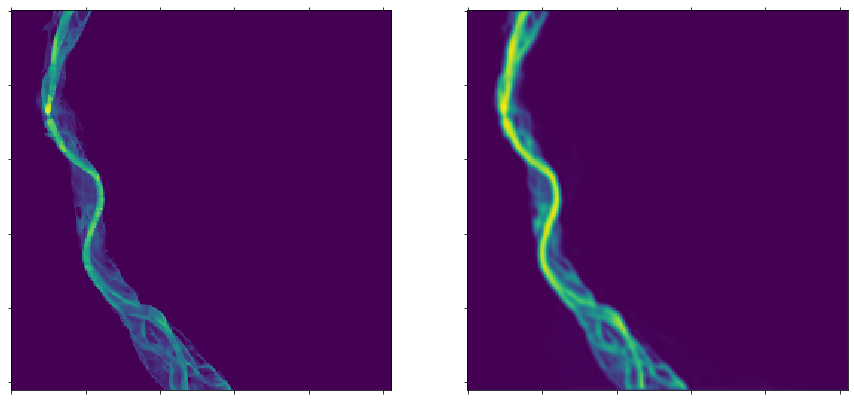

epoch 51 -- avg loss: 0.023463295094226812
[!] Comparison matrices printed


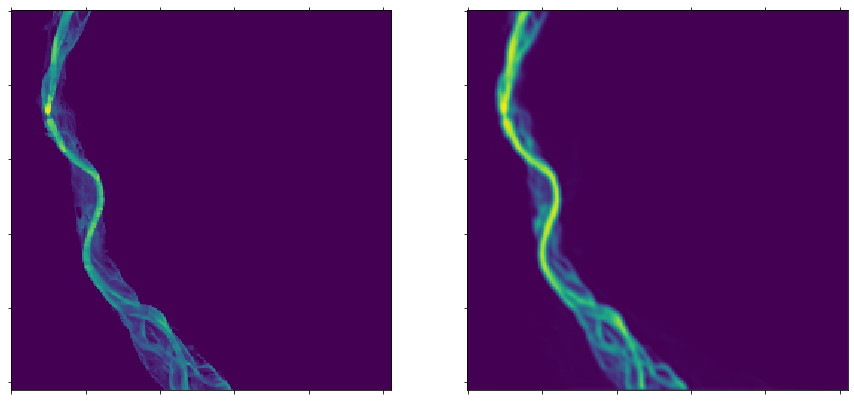

epoch 52 -- avg loss: 0.02318165091049696
[!] Comparison matrices printed


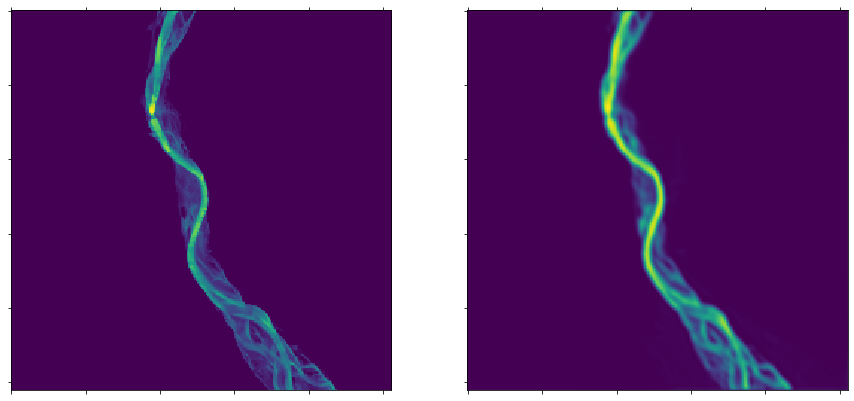

epoch 53 -- avg loss: 0.022909033257355098
[!] Comparison matrices printed


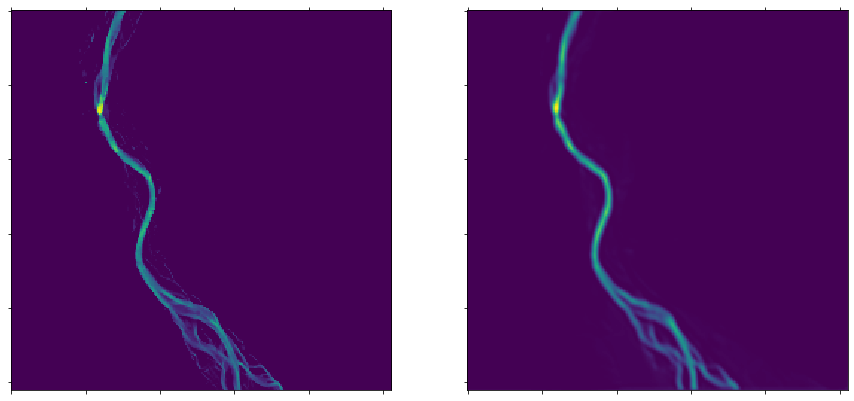

epoch 54 -- avg loss: 0.022645012358172744
[!] Comparison matrices printed


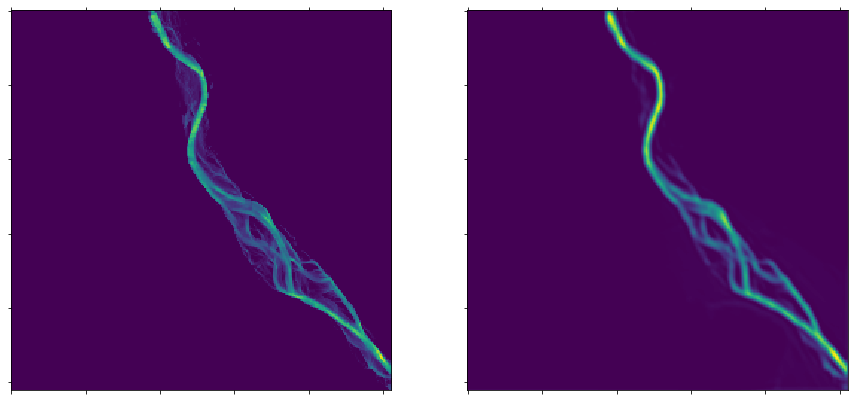

epoch 55 -- avg loss: 0.02238918736980708
[!] Comparison matrices printed


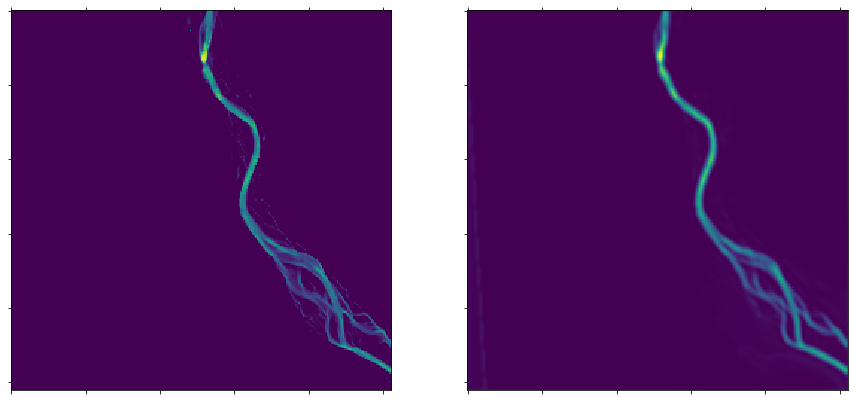

epoch 56 -- avg loss: 0.02214118108458585
[!] Comparison matrices printed


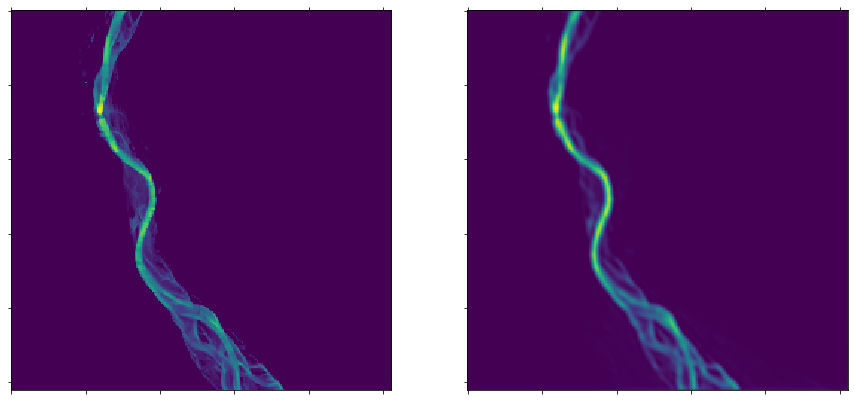

KeyboardInterrupt: 

In [50]:
epochs = 200

for epoch in range(epochs):  # loop over the dataset multiple times

    for i, batch in enumerate(X_train):

        optimizer.zero_grad()

        # ---- Predicting
        #print(X_train.shape)
        #print(batch.shape)
        outputs = net(batch,1) # 0 for layer index, 0 for h index

        # ---- Batch Loss
        loss = criterion(outputs[:,0,:,:], y_train[i,:,0,0,:,:])
        #loss += mass_conservation_loss(outputs[:,0,:,:], y_train[i,:,0,0,:,:])
        '''
        loss = None
        for x in range(outputs.shape[1]):
            img1 = Variable( outputs[x,0,:,:].unsqueeze(0).unsqueeze(0),  requires_grad=False)
            img2 = Variable( y_train[i,x,0,0,:,:].unsqueeze(0).unsqueeze(0), requires_grad = True)

            if loss is None: loss = -criterion(img1, img2)
            else: loss += -criterion(img1, img2)

            loss += mass_conservation_loss(img1, img2)

            #print("ssim loss: \t{}".format(-criterion(img1, img2)))
            #print("mass conservation loss:\t{}".format(mass_conservation_loss(img1, img2)))
        '''
        loss.backward()
        optimizer.step()

        # print statistics
        losses.append(loss.item())

        #print("batch {} - loss {}".format(i, loss.item()))

    if epoch % 1 == 0:

        print("epoch {} -- avg loss: {}".format(epoch, np.mean(losses)))

        k = np.random.randint(len(X_train))

        outputs = net(X_train[k],1) # 0 for layer index, 0 for h index

        #np.savetxt('output.txt',outputs[0,0,:,:].cpu().detach().numpy(),fmt='%.2f')
        #np.savetxt('real.txt',y_train[k,0,0,0].cpu().detach().numpy(),fmt='%.2f')

        print("[!] Comparison matrices printed")

        #------------------------------
        fig, axs = plt.subplots(1, 2, figsize=(plotsize,plotsize))

        for ax in axs:
            ax.set_yticklabels([])
            ax.set_xticklabels([])

        # pick random datapoint from batch
        x = np.random.randint(X_train[k].shape[0])

        for i,frame in enumerate(X_train[k,x,-1:]):
            axs[i].matshow(frame[0].cpu().detach().numpy())

        #predicted = th.mm(outputs[x][0], X_train[k,x,-1,1])
        axs[i+1].matshow(outputs[x][0][0].cpu().detach().numpy())
        #axs[i+2].matshow(outputs[x][1].cpu().detach().numpy())
        #axs[i+3].matshow(outputs[x][2].cpu().detach().numpy())

        plt.show()
        #------------------------------

        #if epoch % 10 == 0:
        #    print('[%d, %5d] loss: %.3f' %
        #          (epoch + 1, i + 1, running_loss / 2000))
        #    running_loss = 0.0

print('Finished Training')

In [ ]:
'''
num_run = len(os.listdir("runs/")) + 1
now = datetime.now()
foldername = "train_{}_{}".format(num_run, now.strftime("%d_%m_%Y_%H_%M_%S"))
os.mkdir("runs/" + foldername)

weights_path = "runs/" + foldername + "/model.weights"
th.save(net.state_dict(), weights_path)
'''

In [ ]:
mpl.rcParams['text.color'] = 'k'

plt.title("loss")
plt.plot(range(len(losses)), losses)
pass

In [ ]:
'''
plt.title("relative error")
plt.plot(range(len(errors)), errors, label="train")
plt.plot(range(len(test_errors)), test_errors, label="test")
plt.legend()
pass


In [ ]:
mpl.rcParams['text.color'] = 'w'
prep = Preprocessing()

In [ ]:
j = np.random.randint(len(y_test))
j = 3
m = 2
k = 4

print("k = {}".format(k))

#k = 5
input = th.unsqueeze(X_test[j, m], 0)
outputs = net(input)

#------------------------------
num_predicted_frames = outputs[0, 0].shape[0] # per allineare frames passati e futuri
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(input[0,0,-num_predicted_frames:]):
    frame = frame.cpu().detach().numpy()
    axs[i].matshow(frame)
    axs[i].set_title('t = {}'.format(i))

print("======== Past frames ========")
plt.show()

print("======== True Future vs Predicted frames ========")

#------------------------------
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(y_test[j,m,0]):
    axs[i].matshow(frame.cpu().detach().numpy())
    axs[i].set_title('t = {}'.format(i+num_predicted_frames))

plt.show()
#------------------------------
fig, axs = plt.subplots(1, outputs[0,0].shape[0], figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(outputs[0,0]):
    attention_mask = outputs[0,1,i].cpu().detach().numpy()
    y_frame = frame.cpu().detach().numpy()
    y_true = y_test[j,m,0,i].cpu().detach().numpy()

    y_frame = np.dot(y_frame, attention_mask)
    y_true = np.dot(y_true, attention_mask)

    print(y_frame[:5,:5])
    print("#-------------")
    print(y_true[:5,:5])
    print("\n\n")

    ssim = prep.pytorch_ssim(y_true, y_frame).item()
    axs[i].matshow(y_frame)
    axs[i].set_title('ssim = {}'.format(ssim))

plt.show()
#------------------------------

In [ ]:
print("k = {}".format(k))
iterations = 4
#k = 5

input = th.unsqueeze(X_train[k,0], 0)
outputs = net(input)

#------------------------------
print("======== Past frames ========")
num_predicted_frames = outputs[0,0].shape[0] # per allineare frames passati e futuri
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(input[0,0,-num_predicted_frames:]):
    axs[i].matshow(frame.cpu().detach().numpy())
    axs[i].set_title('t = {}'.format(i))

plt.show()
#------------------------------
print("======== True vs Autoregressive Pred Frames  ========")
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

true_means = []

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(y_train[k,0,0]):
    axs[i].matshow(frame.cpu().detach().numpy())
    axs[i].set_title('t = {}'.format(i+num_predicted_frames))
    true_means.append(frame.cpu().detach().numpy().mean())

plt.show()
#------------------------------

#i = np.random.randint(len(X_test))
input = th.unsqueeze(X_train[k][0], 0)

fig, axs = plt.subplots(1, iterations, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

predicted_means = []
for x in range(iterations):
    # first predicted frame only
    output = th.unsqueeze(net(input)[:,:,0,:,:],2)
    # next frame = first predicted from output + btm map
    next_frame = output.detach()
    next_frame = th.cat((next_frame, th.unsqueeze(input[:,2:,0,:,:],2)), axis=1)
    # added on top of (input sequence - first frame)
    input = th.cat((next_frame, input[:,:,1:,:]), axis=2)

    axs[x].matshow(output[0,0,0].cpu().detach().numpy())
    axs[x].set_title('t = {}'.format(x+num_predicted_frames))
    predicted_means.append(output[0,0,0].cpu().detach().numpy().mean())
    #print(np.mean(output[0,0,0].cpu().detach().numpy()))

plt.show()

In [ ]:
mpl.rcParams['text.color'] = 'b'

plt.clf()
plt.plot(range(len(true_means)), true_means,  "-b", label="True frames mean")
plt.plot(range(len(true_means)), true_means,  "*")

plt.plot(range(len(predicted_means)), predicted_means,  "-g", label="Predicted frames mean")
plt.plot(range(len(predicted_means)), predicted_means,  "*")
plt.grid()
plt.legend()
pass

In [ ]:
print("{:<20s}{:<20s}{:<20s}{:<20s}{:<20s}".format("", "min", "max", "mean", "std"))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("prediction", th.min(outputs), th.max(outputs), th.mean(outputs), th.std(outputs)))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("true", th.min(y_test[0]), th.max(y_test[0]), th.mean(y_test[0]), th.std(y_test[0])))
'''